# ltc_distribution_experimentation_analysis

> Look at the LTC distribution

This notebook will analyse the result of the LTC distribution simulations

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))

In [2]:
#| default_exp ltc_analysis

In [3]:
#| export

import jax
import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit
from jax.config import config

jax.default_device(jax.devices('cpu')[0])
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", False)
config.update("jax_platform_name", "cpu")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
#| export

import CE_simulation.mesh as msh
import CE_simulation.tension as tns
import CE_simulation.delaunay as dln
import CE_simulation.isogonal as iso
import CE_simulation.drosophila as drs
import CE_simulation.disorder as dis
import CE_simulation.hessian as hes
import CE_simulation.ecmc as ecm
import CE_simulation.phase_analysis as ana

In [5]:
#| export

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection

from tqdm.notebook import tqdm

from scipy import spatial, ndimage
from skimage.transform import downscale_local_mean

from collections import Counter
import itertools

from copy import deepcopy
import os
import pickle

In [6]:
#| export

from joblib import Parallel, delayed
import gc

In [7]:
#| export

from typing import Sequence, Union, Dict, List, Tuple, Iterable, Callable, Any
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [8]:
## reloading the modules in case you edit them

import importlib

importlib.reload(msh); importlib.reload(tns); importlib.reload(dln); importlib.reload(iso);
importlib.reload(drs); importlib.reload(dis); importlib.reload(ecm);

In [156]:
def std_err(arr, axis=-1):
    return np.std(arr, axis=axis)/np.sqrt(arr.shape[axis])

In [157]:
plot_dir = "/home/fbrauns/Nikolas/code/CE_simulation/plots/v2"

## Loading and evaluating the LTC / isogonal stretching simulation

In [135]:
base_dir = "/data/Nikolas/GBE_simulation/runs/ltc_distribution/ltc_distribution_isogonal_new_post_T1_once_more"

n_steps = 500 #500 # 500 no need for 500
step = 5 # might want higher step! e.g. 5

def load_data(orientation, isogonal, random_seed, return_meshes=False):
    sim_dir = f"{base_dir}/orientation_{orientation}_isogonal_{isogonal}_randomSeed_{random_seed}"
    try:
        meshes = [iso.CellHalfEdgeMesh.load_mesh(f'{sim_dir}/{str(i).zfill(4)}_mesh')
                 for i in tqdm(range(0, n_steps, step))]

        valences = [ecm.get_valences(m) for m in meshes]
        anisos_S = np.stack([ana.get_anisos_S(m) for m in meshes])

        delta_series = [ana.get_width_height(m, q=0.8) for m in meshes]
        delta_series = ndimage.gaussian_filter1d(np.stack(delta_series)/delta_series[1], axis=0, sigma=1)
        delta_series = np.log(delta_series)
        elongation = np.exp((delta_series[:,0]-delta_series[:,1])/2)
        
        try:
            with open(f"{sim_dir}/last_flipped_edges.pickle", "rb") as f:
                last_flipped_edges = pickle.load(f)
        except FileNotFoundError:
            last_flipped_edges = [[] for i in range(len(meshes)+1)]
        T1_rate = [len(x) for x in last_flipped_edges[1:]]
        ltc_dist = [tns.angles_shape(np.array(list(m.get_vertex_angles(exclude=None, method="dual").values())).T)
                    for m in meshes]

        return_dict = {"params": (orientation, isogonal, random_seed),
                       "valences": valences, "anisos_S": anisos_S,
                       "T1_rate": T1_rate, "elongation": elongation, "LTC": ltc_dist}
        if return_meshes:
            return_dict["meshes"] = meshes
        else:
            del meshes
            gc.collect()
    except ValueError:
        print((orientation, isogonal, random_seed))
        return_dict = {"params": (orientation, isogonal, random_seed),
                       "valences": None, "anisos_S": None,
                       "T1_rate": None, "elongation": None, "LTC": None}
        if return_meshes:
            return_dict["meshes"] = None
    return return_dict


In [136]:
elongation_dict = {}
valence_dict = {}
anisos_dict_S = {}

T1_rate_dict = {}
T1_rate_raw_dict = {}
LTC_dict = {}
meshes_dict = {}

In [137]:
orientations = ["parallel", "orthogonal"]
isogonals = [0, 0.25, 0.3333333333333333, 0.35]  # note: 0.35 is temporally ramped!!
reps = [1, 2, 3]

to_be_loaded = list(itertools.product(orientations, isogonals, reps))

In [138]:
len(to_be_loaded)

24

In [139]:
%%time

my_data = Parallel(n_jobs=24, prefer=None, timeout=99999)(delayed(load_data)(orientation, isogonal, random_seed, return_meshes=True) 
                                                          for orientation, isogonal, random_seed in to_be_loaded)

# should take 2 mins if all jobs run parallel

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and

CPU times: user 2min 25s, sys: 51.3 s, total: 3min 16s
Wall time: 4min 5s


In [145]:
dt = 0.005
dt_eff = step * dt * 25

for item in my_data:
    if item["T1_rate"] is not None:
        n_cells = len(item["meshes"][0].vertices)
        key = item["params"]
        elongation_dict[key] = item["elongation"]
        valence_dict[key] = item["valences"]
        anisos_dict_S[key] = item["anisos_S"]
        LTC_dict[key] = item["LTC"]
        meshes_dict[key] = item["meshes"]
        if item["T1_rate"] is not None:
            T1_rate_raw_dict[key] = np.array(item["T1_rate"]) / n_cells
            T1_rate_dict[key] = downscale_local_mean(np.array(item["T1_rate"]), step) / (n_cells*dt_eff)
            T1_rate_dict[key] = T1_rate_dict[key][:int(n_steps/step + 1)]
        else:
            T1_rate_dict[key] = item["T1_rate"] 

In [146]:
hex_dict = {key: [x[6] for x in val] for key, val in valence_dict.items()}

In [147]:
T1_rate_dict[key].shape, T1_rate_raw_dict[key].shape

((101,), (501,))

In [148]:
## set time

dt = 0.005
time = np.arange(elongation_dict[key].shape[0]) * step * dt * 25

In [149]:
## compute averages over realizations, create pooled LTC distributions, across the three replicates

params = list(set([x[:-1] for x in to_be_loaded])) # unique parameter values
elongation_dict_mean = {key: np.mean([elongation_dict[key+(i,)] for i in reps], axis=0) for key in params}

T1_rate_dict_mean = {key: np.mean([T1_rate_dict[key+(i,)] for i in reps], axis=0) for key in params}
anisos_dict_mean = {key: np.mean([anisos_dict_S[key+(i,)] for i in reps], axis=0) for key in params}
# special case - this is a distribution
ltc_dict_mean = {key: np.vstack([np.array(LTC_dict[key+(i,)]).T for i in reps]).T for key in params}

## LTC distribution - Medians

(0.0, 40.0)

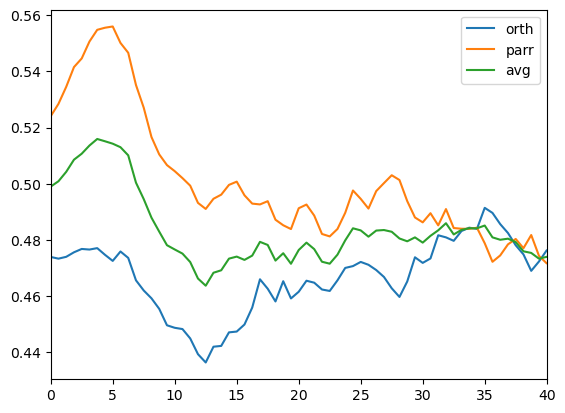

In [150]:
# isogonal = 0

plt.plot(time, np.median(ltc_dict_mean[("orthogonal", 0)], axis=-1)[:,0]/np.pi, label="orth")
plt.plot(time, np.median(ltc_dict_mean[("parallel", 0)], axis=-1)[:,0]/np.pi, label="parr")
plt.plot(time, (np.median(ltc_dict_mean[("orthogonal", 0)], axis=-1)[:,0]+np.median(ltc_dict_mean[("parallel", 0)], axis=-1)[:,0])/(2*np.pi), label="avg")

plt.legend()
plt.xlim([0, 40])

(0.0, 40.0)

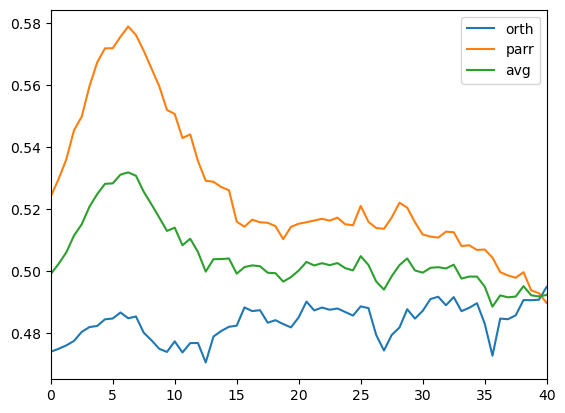

In [151]:
# isogonal = 0.25

plt.plot(time, np.median(ltc_dict_mean[("orthogonal", 0.25)],axis=-1)[:,0]/np.pi, label="orth")
plt.plot(time, np.median(ltc_dict_mean[("parallel", 0.25)],axis=-1)[:,0]/np.pi, label="parr")
plt.plot(time, (np.median(ltc_dict_mean[("orthogonal", 0.25)],axis=-1)[:,0]+np.median(ltc_dict_mean[("parallel", 0.25)],axis=-1)[:,0])/(2*np.pi), label="avg")

plt.legend()
plt.xlim([0, 40])

(0.0, 40.0)

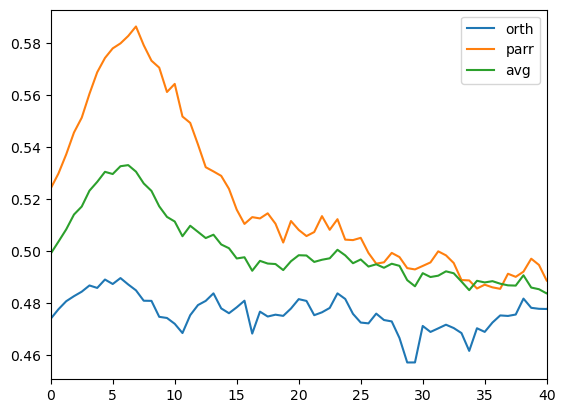

In [152]:
# isogonal = 0.333


plt.plot(time, np.median(ltc_dict_mean[("orthogonal", 0.35)],axis=-1)[:,0]/np.pi, label="orth")
plt.plot(time, np.median(ltc_dict_mean[("parallel", 0.35)],axis=-1)[:,0]/np.pi, label="parr")
plt.plot(time, (np.median(ltc_dict_mean[("orthogonal", 0.35)],axis=-1)[:,0]+np.median(ltc_dict_mean[("parallel", 0.25)],axis=-1)[:,0])/(2*np.pi), label="avg")

plt.legend()
plt.xlim([0, 40])

(0.0, 40.0)

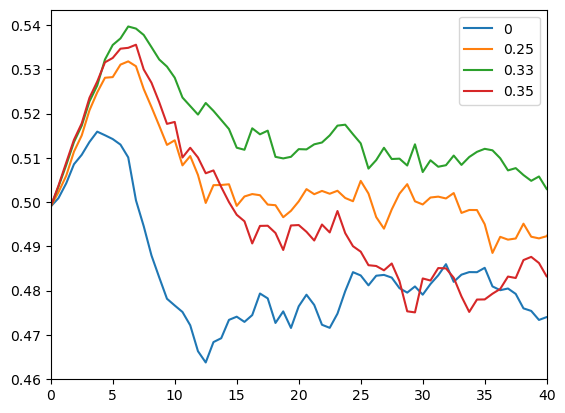

In [153]:
# one vs the other

plt.plot(time, (np.median(ltc_dict_mean[("orthogonal", 0)],axis=-1)[:,0]+np.median(ltc_dict_mean[("parallel", 0)],axis=-1)[:,0])/(2*np.pi), label="0")
plt.plot(time, (np.median(ltc_dict_mean[("orthogonal", 0.25)],axis=-1)[:,0]+np.median(ltc_dict_mean[("parallel", 0.25)],axis=-1)[:,0])/(2*np.pi), label="0.25")
plt.plot(time, (np.median(ltc_dict_mean[("orthogonal", 0.3333333333333333)],axis=-1)[:,0]
                +np.median(ltc_dict_mean[("parallel", 0.3333333333333333)],axis=-1)[:,0])/(2*np.pi), label="0.33")
plt.plot(time, (np.median(ltc_dict_mean[("orthogonal", 0.35)],axis=-1)[:,0]
                +np.median(ltc_dict_mean[("parallel", 0.35)],axis=-1)[:,0])/(2*np.pi), label="0.35")

plt.legend()
plt.xlim([0, 40])

In [158]:
## make main plot : median vs time

isogonal = 0.25

median_ltc = (np.median(ltc_dict_mean[("orthogonal", isogonal)],axis=-1)+np.median(ltc_dict_mean[("parallel", isogonal)],axis=-1))/2

quartile_bottom_ltc = (np.quantile(ltc_dict_mean[("orthogonal",isogonal)],0.25,axis=-1)+np.quantile(ltc_dict_mean[("parallel", isogonal)], 0.25,axis=-1))/2

quartile_top_ltc = (np.quantile(ltc_dict_mean[("orthogonal",isogonal)],0.75,axis=-1)+np.quantile(ltc_dict_mean[("parallel", isogonal)], 0.75,axis=-1))/2

std_err = (std_err(ltc_dict_mean[("orthogonal", isogonal)],axis=-1)+std_err(ltc_dict_mean[("parallel", isogonal)],axis=-1))/2

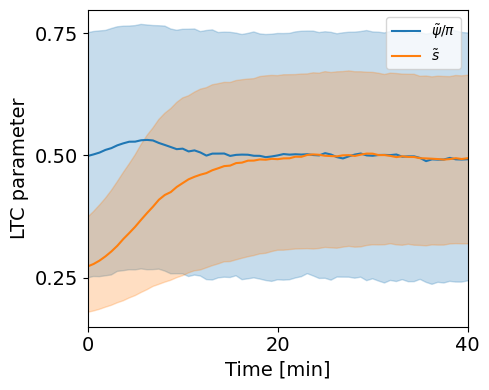

In [210]:
fig = plt.figure(figsize=(5, 4))

plt.plot(time, median_ltc[:,0]/np.pi, label=r"$\tilde{\psi}/\pi$")
plt.fill_between(time, quartile_bottom_ltc[:,0]/np.pi, quartile_top_ltc[:,0]/np.pi, color="tab:blue", alpha=0.25)

plt.plot(time, median_ltc[:,1], label=r"$\tilde{s}$")
plt.fill_between(time, quartile_bottom_ltc[:,1], quartile_top_ltc[:,1], color="tab:orange", alpha=0.25)

plt.legend()

plt.xlim([0, 40])
plt.xlabel("Time [min]", fontsize=14)
plt.ylabel("LTC parameter", fontsize=14)
plt.xticks([0, 20, 40], fontsize=14)
plt.yticks([0.25, 0.5, 0.75], fontsize=14)

plt.tight_layout()

plt.savefig(f"{plot_dir}/fig_5_ltc/median_ltc_vs_time_isogonal_ramp.pdf")

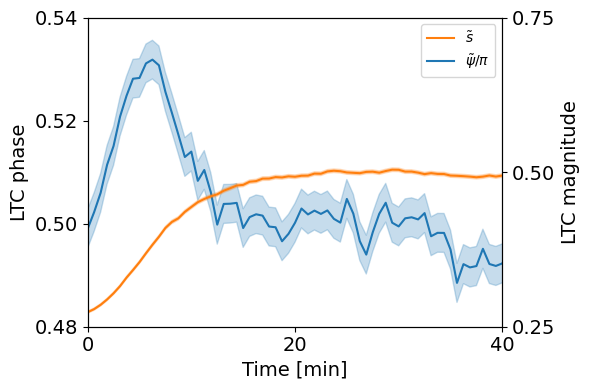

In [211]:
fig = plt.figure(figsize=(6, 4))

plt.plot(time, median_ltc[:,0]/np.pi, label=r"$\tilde{\psi}/\pi$")
plt.fill_between(time, (median_ltc[:,0]-std_err[:,0])/np.pi, (median_ltc[:,0]+std_err[:,0])/np.pi, color="tab:blue", alpha=0.25)
plt.ylabel("LTC phase", fontsize=14)
plt.yticks([0.48, 0.5, 0.52, 0.54], fontsize=14)
plt.xlabel("Time [min]", fontsize=14)
plt.xticks([0, 20, 40], fontsize=14)


ax = plt.gca().twinx()
ax.plot(time, median_ltc[:,1], label=r"$\tilde{s}$", color="tab:orange")
ax.fill_between(time, (median_ltc[:,1]-std_err[:,1]), (median_ltc[:,1]+std_err[:,1]), color="tab:orange", alpha=0.25)

plt.plot([],[], color="tab:blue", label=r"$\tilde{\psi}/\pi$")
plt.legend()

plt.xlim([0, 40])
plt.yticks([0.25, 0.5, 0.75], fontsize=14)
plt.ylabel("LTC magnitude", fontsize=14)

plt.tight_layout()

plt.savefig(f"{plot_dir}/fig_5_ltc/median_ltc_vs_time_isogonal_ramp_std_err.pdf")

In [231]:
#| export

def weighted_quantiles(values, weights, quantiles=0.5):
    """Source: https://stackoverflow.com/questions/20601872/numpy-or-scipy-to-calculate-weighted-median"""
    i = np.argsort(values)
    c = np.cumsum(weights[i])
    return values[i[np.searchsorted(c, np.array(quantiles) * c[-1])]]

In [238]:
phase_median_weighted = np.stack([weighted_quantiles(x[0], x[1]) for x in ltc_dict_mean[("orthogonal", isogonal)]])
phase_median_weighted += np.stack([weighted_quantiles(x[0], x[1]) for x in ltc_dict_mean[("parallel", isogonal)]])
phase_median_weighted /= 2

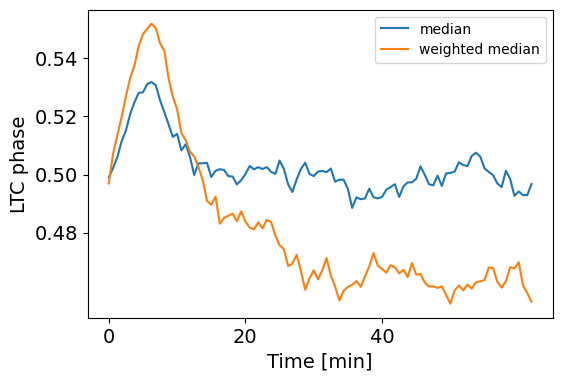

In [240]:
fig = plt.figure(figsize=(6, 4))

plt.plot(time, median_ltc[:,0]/np.pi, label=r"median")
plt.plot(time, phase_median_weighted/np.pi, label=r"weighted median")

plt.ylabel("LTC phase", fontsize=14)
plt.yticks([0.48, 0.5, 0.52, 0.54], fontsize=14)
plt.xlabel("Time [min]", fontsize=14)
plt.xticks([0, 20, 40], fontsize=14)

plt.legend()

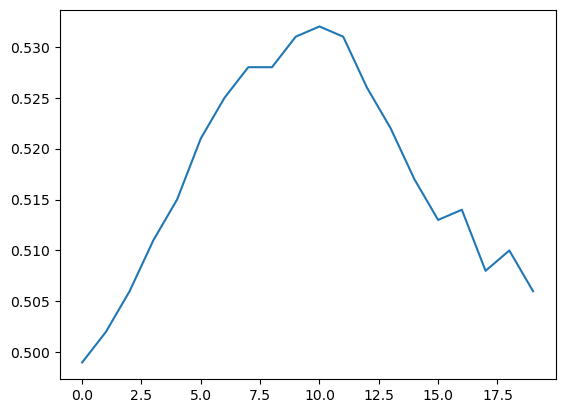

In [165]:
plt.plot(np.round(median_ltc[:,0]/np.pi, decimals=3)[:20])

In [ ]:
# step: 5. so maximum shape index around time step 50 out of 500.

In [65]:
## plan  how to schedule the reference shape
from jax.nn import relu

(0.0, 0.45)

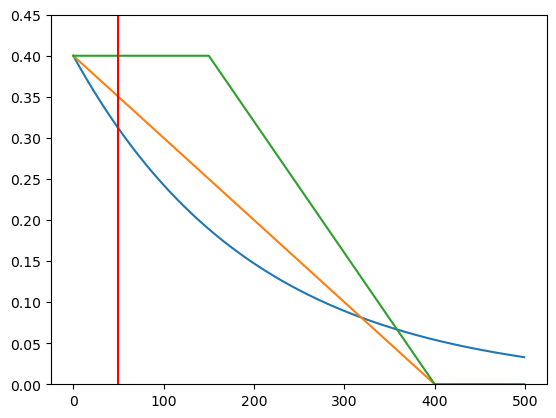

In [202]:
aniso_max = 0.4
dt = 0.005

sim_steps = np.arange(500)


plt.plot(sim_steps, aniso_max * np.exp(-sim_steps*dt))

plt.plot(sim_steps, aniso_max * relu(1-sim_steps/400))

plt.plot(sim_steps, aniso_max * relu(1-relu(sim_steps-150)/250) )


plt.vlines(50, 0, 0.45, color="r")

plt.ylim([0, 0.45])

## LTC distribution - Histograms

In [181]:
bins = [dln.eqspace(0, 1+.01, .1), dln.eqspace(0, 1+.01, .1)] # for histograms

isogonal = 0.35

ltc_combined = np.vstack([ltc_dict_mean[("orthogonal", isogonal)].T, ltc_dict_mean[("parallel", isogonal)].T]).transpose((1, 2, 0))
ltc_combined.shape

(2, 100, 11832)

In [182]:
def flatten_t(arr):
    return arr.reshape((arr.shape[0], arr.shape[1]*arr.shape[2])) 

In [216]:
early = flatten_t(ltc_combined[:,:2])
mid = flatten_t(ltc_combined[:,10:12]) # 8-12
late = flatten_t(ltc_combined[:,70:90])

In [197]:
early.shape, ltc_combined.shape

((2, 23664), (2, 100, 11832))

In [198]:
[np.savetxt(f"{plot_dir}/fig_5_ltc/ltc_data/{str(ix).zfill(3)}.txt", x) for ix, x in enumerate(ltc_combined.transpose((1,0,2)))]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [226]:
time[70:90].mean(), time[10:12].mean()

(49.6875, 6.5625)

In [227]:
np.savetxt(f"{plot_dir}/fig_5_ltc/ltc_t=0min.txt", early)
np.savetxt(f"{plot_dir}/fig_5_ltc/ltc_t=7min.txt", mid)
np.savetxt(f"{plot_dir}/fig_5_ltc/ltc_t=50min.txt", late)

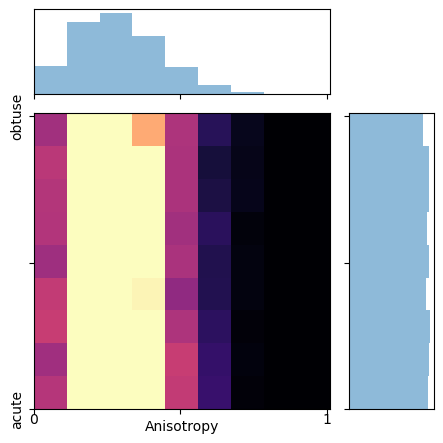

In [223]:
## early

fig = plt.figure(figsize=(5, 5))

ax = dln.scatter_hist(early[1], early[0]/np.pi, bins, fig=fig, vmax=1.8)

ax.set_ylabel("", labelpad=-5)
ax.set_xlabel("Anisotropy", labelpad=-5)
ax.set_xticks([0, 1/2, 1], [0, "", 1], rotation=0, va='center') 
ax.set_yticks([0, 1/2, 1], ["acute", "", r"obtuse"], rotation=90, va='center')

plt.savefig(f"{plot_dir}/fig_5_ltc/ltc_t=0min.pdf")

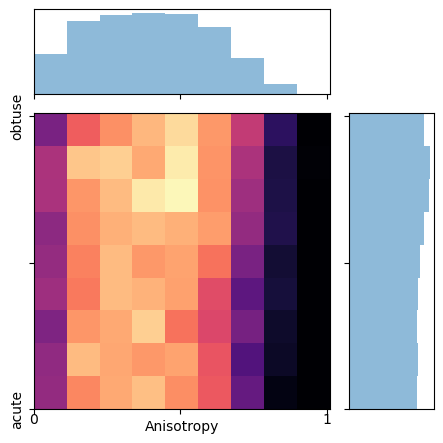

In [224]:
## mid

fig = plt.figure(figsize=(5, 5))

ax = dln.scatter_hist(mid[1], mid[0]/np.pi, bins, fig=fig, vmax=1.8)

ax.set_ylabel("", labelpad=-5)
ax.set_xlabel("Anisotropy", labelpad=-5)
ax.set_xticks([0, 1/2, 1], [0, "", 1], rotation=0, va='center') 
ax.set_yticks([0, 1/2, 1], ["acute", "", r"obtuse"], rotation=90, va='center')
plt.savefig(f"{plot_dir}/fig_5_ltc/ltc_t=7min.pdf")

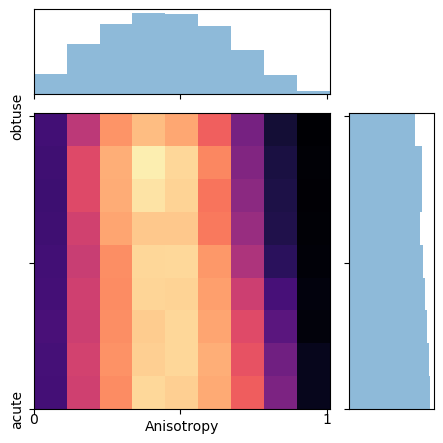

In [225]:
## late

fig = plt.figure(figsize=(5, 5))

ax = dln.scatter_hist(late[1], late[0]/np.pi, bins, fig=fig, vmax=1.8)

ax.set_ylabel("", labelpad=-5)
ax.set_xlabel("Anisotropy", labelpad=-5)
ax.set_xticks([0, 1/2, 1], [0, "", 1], rotation=0, va='center') 
ax.set_yticks([0, 1/2, 1], ["acute", "", r"obtuse"], rotation=90, va='center')
plt.savefig(f"{plot_dir}/fig_5_ltc/ltc_t=50min.pdf")

### plotting some meshes, to check all makes sense

Cells are isogonally stretched, as expected

In [ ]:
bdry_x, bdry_y = (30, 20)

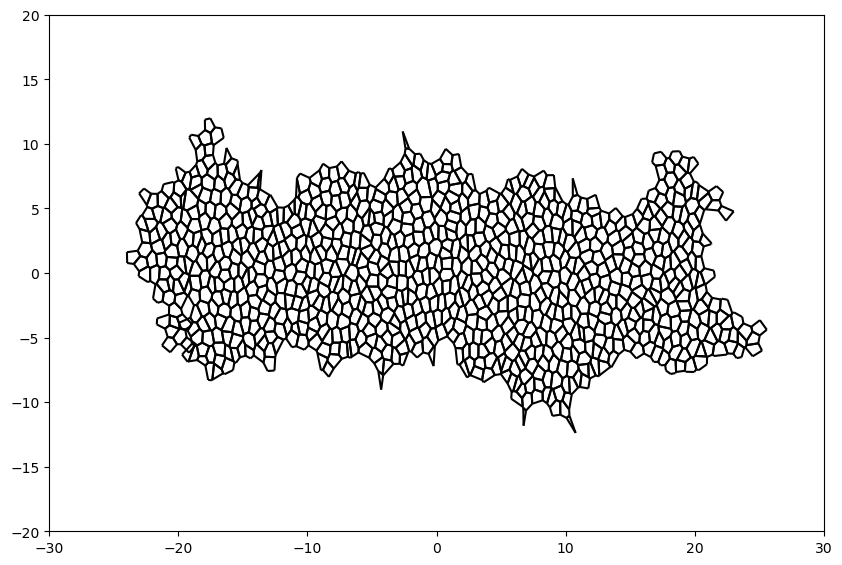

In [ ]:
t = -1

orientation = "parallel"
isogonal = 0.25
rep = 1

fig, ax = plt.subplots(figsize=(10, 10))

meshes_dict[(orientation, isogonal, rep)][t].cellplot()

ax.set_xlim([-bdry_x, bdry_x])
ax.set_ylim([-bdry_y, bdry_y])
ax.set_aspect("equal", adjustable="box")

## Analysis of saturating feedback simulations

In [77]:
base_dir = "/data/Nikolas/GBE_simulation/runs/ltc_distribution/saturating_feedback_once_more"

n_steps = 500 # 500 no need for 500
step = 1 #5 # might want higher step! e.g. 5

def load_data(orientation, TPlus, random_seed, return_meshes=False):
    sim_dir = f"{base_dir}/orientation_{orientation}_TPlus_{TPlus}_randomSeed_{random_seed}"
    try:
        meshes = [iso.CellHalfEdgeMesh.load_mesh(f'{sim_dir}/{str(i).zfill(4)}_mesh')
                 for i in tqdm(range(0, n_steps, step))]

        valences = [ecm.get_valences(m) for m in meshes]
        anisos_S = np.stack([ana.get_anisos_S(m) for m in meshes])

        delta_series = [ana.get_width_height(m, q=0.8) for m in meshes]
        delta_series = ndimage.gaussian_filter1d(np.stack(delta_series)/delta_series[1], axis=0, sigma=1)
        delta_series = np.log(delta_series)
        elongation = np.exp((delta_series[:,0]-delta_series[:,1])/2)
        
        with open(f"{sim_dir}/last_flipped_edges.pickle", "rb") as f:
            last_flipped_edges = pickle.load(f)
        T1_rate = [len(x) for x in last_flipped_edges[1:]]
        ltc_dist = [tns.angles_shape(np.array(list(m.get_vertex_angles(exclude=None, method="dual").values())).T)
                    for m in meshes]

        return_dict = {"params": (orientation, TPlus, random_seed),
                       "valences": valences, "anisos_S": anisos_S,
                       "T1_rate": T1_rate, "elongation": elongation, "LTC": ltc_dist}
        if return_meshes:
            return_dict["meshes"] = meshes
        else:
            del meshes
            gc.collect()
    except ValueError:
        print((orientation, TPlus, random_seed))
        return_dict = {"params": (orientation, isogonal, random_seed),
                       "valences": None, "anisos_S": None,
                       "T1_rate": None, "elongation": None, "LTC": None}
        if return_meshes:
            return_dict["meshes"] = None
    return return_dict


In [78]:
elongation_dict = {}
valence_dict = {}
anisos_dict_S = {}

T1_rate_dict = {}
T1_rate_raw_dict = {}
LTC_dict = {}
meshes_dict = {}

In [79]:
orientations = ["parallel", "orthogonal"]
TPluses = [1.2, 3.33, np.inf] 
reps = [1, 2, 3]

to_be_loaded = list(itertools.product(orientations, TPluses, reps))

In [80]:
len(to_be_loaded)

18

In [81]:
%%time

my_data = Parallel(n_jobs=18, prefer=None, timeout=99999)(delayed(load_data)(orientation, Tplus, random_seed, return_meshes=True) 
                                                          for orientation, Tplus, random_seed in to_be_loaded)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and

CPU times: user 4min 7s, sys: 50.6 s, total: 4min 58s
Wall time: 6min 41s


In [82]:
dt = 0.005
dt_eff = step * dt * 25

for item in my_data:
    if item["T1_rate"] is not None:
        n_cells = len(item["meshes"][0].vertices)
        key = item["params"]
        elongation_dict[key] = item["elongation"]
        valence_dict[key] = item["valences"]
        anisos_dict_S[key] = item["anisos_S"]
        LTC_dict[key] = item["LTC"]
        meshes_dict[key] = item["meshes"]
        if item["T1_rate"] is not None:
            T1_rate_raw_dict[key] = np.array(item["T1_rate"]) / n_cells
            T1_rate_dict[key] = downscale_local_mean(np.array(item["T1_rate"]), step) / (n_cells*dt*25)
            T1_rate_dict[key] = T1_rate_dict[key][:int(n_steps/step + 1)]
        else:
            T1_rate_dict[key] = item["T1_rate"]
            
hex_dict = {key: [x[6] for x in val] for key, val in valence_dict.items()}

In [83]:
elongation_dict.keys()

dict_keys([('parallel', 1.2, 1), ('parallel', 1.2, 2), ('parallel', 1.2, 3), ('parallel', 3.33, 1), ('parallel', 3.33, 2), ('parallel', 3.33, 3), ('parallel', inf, 1), ('parallel', inf, 2), ('parallel', inf, 3), ('orthogonal', 1.2, 1), ('orthogonal', 1.2, 2), ('orthogonal', 1.2, 3), ('orthogonal', 3.33, 1), ('orthogonal', 3.33, 2), ('orthogonal', 3.33, 3), ('orthogonal', inf, 1), ('orthogonal', inf, 2), ('orthogonal', inf, 3)])

In [84]:
## set time

dt = 0.005
time = np.arange(elongation_dict[to_be_loaded[0]].shape[0]) * step * dt * 25

In [85]:
## compute averages over realizations, create pooled LTC distributions, across the three replicates

params = list(set([x[:-1] for x in to_be_loaded])) # unique parameter values
elongation_dict_mean = {key: np.mean([elongation_dict[key+(i,)] for i in reps], axis=0) for key in params}

T1_rate_dict_mean = {key: np.mean([T1_rate_dict[key+(i,)] for i in reps], axis=0) for key in params}
anisos_dict_mean = {key: np.mean([anisos_dict_S[key+(i,)] for i in reps], axis=0) for key in params}
# special case - this is a distribution
ltc_dict_mean = {key: np.vstack([np.array(LTC_dict[key+(i,)]).T for i in reps]).T for key in params}

#### plot some meshes

In [86]:
bdry_x, bdry_y = (17, 12)

In [87]:
norm = mpl.colors.Normalize(vmin=4, vmax=8)

def valence_to_colormap(val):
    return np.array(mpl.cm.PiYG(norm(val), bytes=True))/255 #PiYG, PRGn, bwr

  0%|          | 0/500 [00:00<?, ?it/s]


(-17.0, 17.0, -12.0, 12.0)

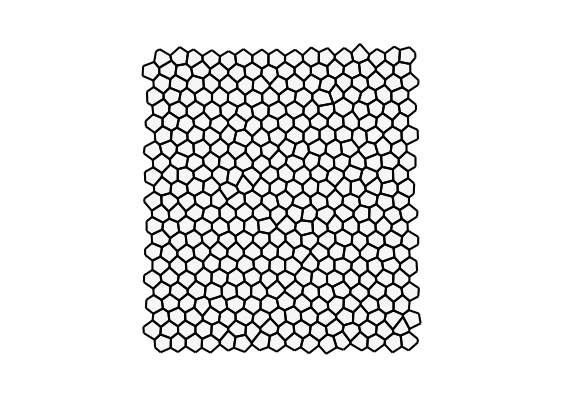

In [88]:
t = 1

orientation = "parallel"
TPlus = 1.2
rep = 1

mesh = meshes_dict[(orientation, TPlus, rep)][t]
fig, ax = plt.subplots(figsize=(7, 7))

mesh.cellplot(cell_colors={key: valence_to_colormap(len(v.faces)) for key, v in mesh.vertices.items() if not v.is_bdry()})

ax.set_xlim([-bdry_x, bdry_x])
ax.set_ylim([-bdry_y, bdry_y])
ax.set_aspect("equal", adjustable="box")
plt.axis("off")

#plt.savefig(f"{plot_dir}/fig_5_ltc/saturating_feedback_0min.pdf")

(-17.0, 17.0, -12.0, 12.0)

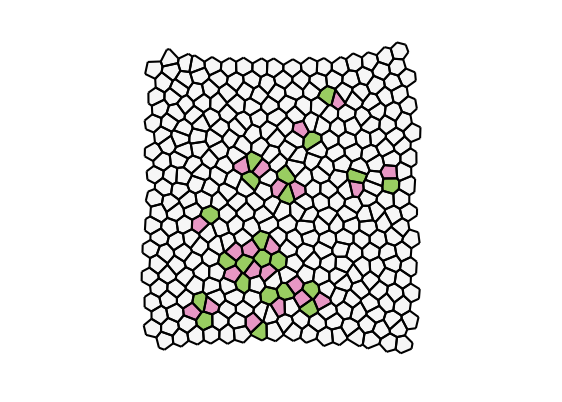

In [89]:
t = 64

orientation = "parallel"
TPlus = 1.2
rep = 1

mesh = meshes_dict[(orientation, TPlus, rep)][t]
fig, ax = plt.subplots(figsize=(7, 7))

mesh.cellplot(cell_colors={key: valence_to_colormap(len(v.faces)) for key, v in mesh.vertices.items() if not v.is_bdry()})

ax.set_xlim([-bdry_x, bdry_x])
ax.set_ylim([-bdry_y, bdry_y])
ax.set_aspect("equal", adjustable="box")
plt.axis("off")

#plt.savefig(f"{plot_dir}/fig_5_ltc/saturating_feedback_40min.pdf")

(-17.0, 17.0, -12.0, 12.0)

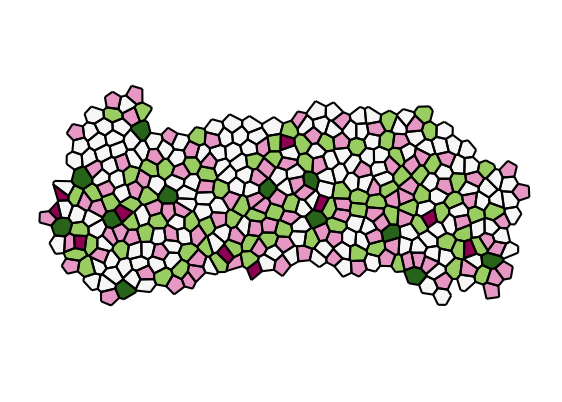

In [ ]:
t = 64

orientation = "parallel"
TPlus = 3.33
rep = 1

mesh = meshes_dict[(orientation, TPlus, rep)][t]
fig, ax = plt.subplots(figsize=(7, 7))

mesh.cellplot(cell_colors={key: valence_to_colormap(len(v.faces)) for key, v in mesh.vertices.items() if not v.is_bdry()})

ax.set_xlim([-bdry_x, bdry_x])
ax.set_ylim([-bdry_y, bdry_y])
ax.set_aspect("equal", adjustable="box")
plt.axis("off")

#plt.savefig(f"{plot_dir}/fig_5_ltc/non-saturating_feedback_40min.pdf")

### making a movie

In [ ]:
orientation = "parallel"
TPlus = 1.2
rep = 1

In [132]:
for t in tqdm(range(1, 321)):
    fig, (ax1, ax2) = plt.subplots(figsize=(14.02, 7.01), ncols=2)

    bdry_x, bdry_y = (17, 11)

    meshes_dict[("parallel", 1.2, 1)][t].cellplot(ax=ax1, cell_colors={key: valence_to_colormap(len(v.faces))
                                                                        for key, v in meshes_dict[("parallel", 1.2, 1)][t].vertices.items() if not v.is_bdry()})
    meshes_dict[("parallel", 3.33, 1)][t].cellplot(ax=ax2, cell_colors={key: valence_to_colormap(len(v.faces))
                                                                        for key, v in meshes_dict[("parallel", 3.33, 1)][t].vertices.items() if not v.is_bdry()})
    for ax in (ax1, ax2):
        ax.set_xlim([-bdry_x, bdry_x])
        ax.set_ylim([-bdry_y, bdry_y])
        ax.set_aspect("equal", adjustable="box")
        ax.axis("off")

    ax1.text(.85, -.1, f"Time: {np.round(t*0.005*25).astype(int)} min", fontsize=16, ha="left", transform=ax1.transAxes)

    ax1.text(.5, 1.02, f"Saturating feedback", fontsize=16, ha="center", transform=ax1.transAxes)
    ax2.text(.5, 1.02, f"Non-saturating feedback", fontsize=16, ha="center", transform=ax2.transAxes)

    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=-.15, hspace=0)
    plt.margins(0,0)


    plt.savefig(f"{plot_dir}/fig_5_ltc/movie_frames/{str(t).zfill(3)}.png", dpi=150, bbox_inches="tight")
    plt.close()

  0%|          | 0/320 [00:00<?, ?it/s]

#### Elongation vs time

In [ ]:
TPlus1 = 1.2 
TPlus2 = 3.33

orientation = "parallel"


sat_extension = np.stack([elongation_dict[(orientation, TPlus1, i)] for i in [1, 2, 3]], axis=0)
sat_extension_mean = np.mean(sat_extension, axis=0)
sat_extension_std = np.std(sat_extension, axis=0)

nonsat_extension = np.stack([elongation_dict[(orientation, TPlus2, i)] for i in [1, 2, 3]], axis=0)
nonsat_extension_mean = np.mean(nonsat_extension, axis=0)
nonsat_extension_std = np.std(nonsat_extension, axis=0)

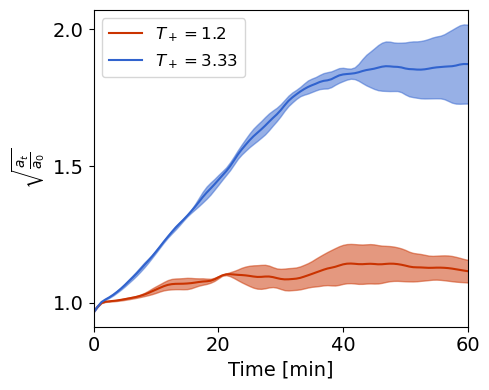

In [ ]:
fig = plt.figure(figsize=(5, 4))

plt.plot(time, sat_extension_mean, color='#ca3300ff', label=r"$T_+ = 1.2$") 
plt.fill_between(time, sat_extension_mean-sat_extension_std,
                 sat_extension_mean+sat_extension_std,  color='#ca3300ff', alpha=0.5)

plt.plot(time, nonsat_extension_mean, color='#3163ceff', label=r"$T_+ = 3.33$") 
plt.fill_between(time, nonsat_extension_mean-nonsat_extension_std,
                 nonsat_extension_mean+nonsat_extension_std,  color='#3163ceff', alpha=0.5)

plt.yticks([1, 1.5, 2], fontsize=14);
plt.xlim([0, 50])
plt.xticks([0, 20, 40, 60], fontsize=14)

plt.legend(fontsize=12, loc="upper left")
plt.xlabel('Time [min]',fontsize=14)
plt.ylabel(r'$\sqrt{\frac{a_t}{a_0}}$', fontsize=14)

plt.tight_layout()
#plt.savefig(f"{plot_dir}/fig_5_ltc/saturating_feedback_elongation.pdf")

#### T1-rate vs time

In [ ]:
TPlus1 = 1.2 
TPlus2 = 3.33

orientation = "parallel"

sigma = 3

reversible_T1_correction_factor = 1.2 # calculated below - some T1s in the saturating simulation are reversible, about 20% (only 1% in the non-saturating case)

T1_sat = np.stack([ndimage.gaussian_filter1d(T1_rate_dict[(orientation, TPlus1, i)], sigma) for i in [1,2,3]])
T1_sat_mean = np.mean(T1_sat, axis=0)[:-1] / reversible_T1_correction_factor
T1_sat_std = np.std(T1_sat, axis=0)[:-1] / reversible_T1_correction_factor


T1_nonsat = np.stack([ndimage.gaussian_filter1d(T1_rate_dict[(orientation, TPlus2, i)], sigma) for i in [1,2,3]])
T1_nonsat_mean = np.mean(T1_nonsat, axis=0)[:-1]
T1_nonsat_std = np.std(T1_nonsat, axis=0)[:-1]

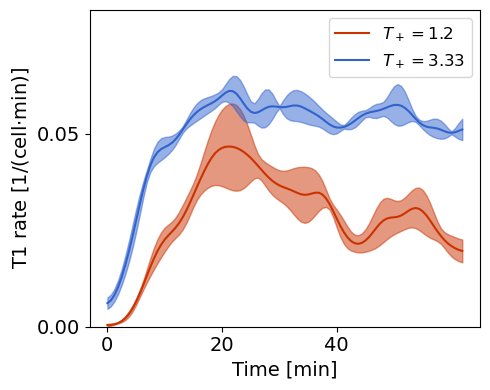

  0%|          | 0/100 [00:00<?, ?it/s]


In [ ]:
fig = plt.figure(figsize=(5, 4))

plt.plot(time, T1_sat_mean, color='#ca3300ff', label=r"$T_+ = 1.2$") 
plt.fill_between(time, T1_sat_mean-T1_sat_std, T1_sat_mean+T1_sat_std,  color='#ca3300ff', alpha=0.5)

plt.plot(time, T1_nonsat_mean, color='#3163ceff',  label=r"$T_+ = 3.33$")
plt.fill_between(time, T1_nonsat_mean-T1_nonsat_std, T1_nonsat_mean+T1_nonsat_std,  color='#3163ceff', alpha=0.5)

plt.yticks([0, 0.05, ], fontsize=14);
plt.ylim([0, 0.082])
plt.xticks([0, 20, 40], fontsize=14)

plt.xlabel('Time [min]',fontsize=14)
plt.ylabel(r'T1 rate [1/(cell$\cdot$min)]', fontsize=14)
plt.legend(fontsize=12, loc="upper right")

plt.tight_layout()
plt.savefig(f"{plot_dir}/fig_5_ltc/saturating_feedback_T1_rate.pdf")

[<matplotlib.lines.Line2D>]

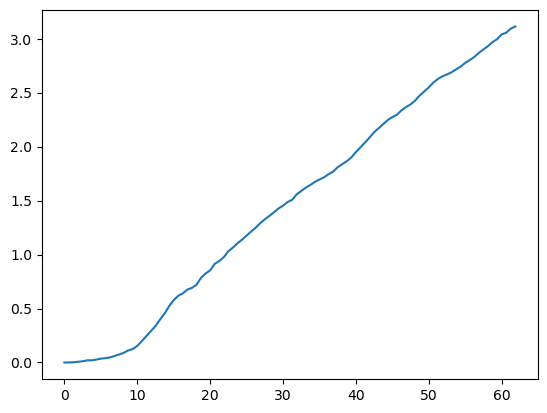

In [ ]:
plt.plot(time, np.cumsum(T1_rate_raw_dict[('orthogonal', 3.33, 1)])[:n_steps][::step] ) # raw t1 rate looks good.

[<matplotlib.lines.Line2D>]

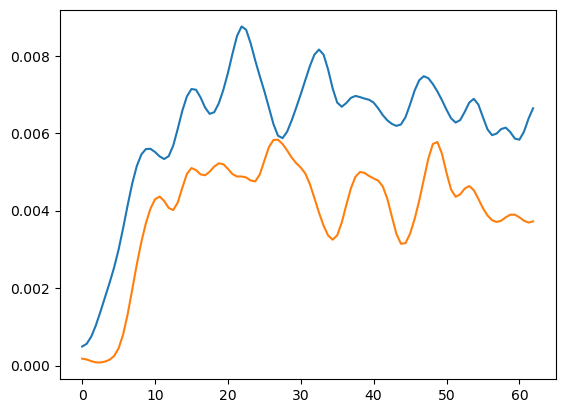

In [ ]:
plt.plot(time, ndimage.gaussian_filter1d(T1_rate_raw_dict[('parallel', 3.33, 1)], sigma=10)[:n_steps][::step] ) # raw t1 rate looks good.

plt.plot(time, ndimage.gaussian_filter1d(T1_rate_raw_dict[('parallel', 1.2, 1)], sigma=10)[:n_steps][::step] ) # raw t1 rate looks good.

### Filtering out duplicate T1s

In [ ]:
## need to filter out reversible T1s  - for this, we need the meshes at all times

n_steps = 500
step = 1

TPlus = 1.2
orientation = "orthogonal" # parallel
random_seed = 2

sim_dir = f"{base_dir}/orientation_{orientation}_TPlus_{TPlus}_randomSeed_{random_seed}"

meshes_sat = [iso.CellHalfEdgeMesh.load_mesh(f'{sim_dir}/{str(i).zfill(4)}_mesh')
                  for i in tqdm(range(1, n_steps, step))]
with open(f"{sim_dir}/property_dict.pickle", "rb") as f:
    property_dict_sat = pickle.load(f)
with open(f"{sim_dir}/last_flipped_edges.pickle", "rb") as f:
    last_flipped_sat = pickle.load(f)

  0%|          | 0/499 [00:00<?, ?it/s]

In [ ]:
n_steps = 500
step = 1

TPlus = 3.33
orientation = "orthogonal" # parallel
random_seed = 2

sim_dir = f"{base_dir}/orientation_{orientation}_TPlus_{TPlus}_randomSeed_{random_seed}"

meshes_nonsat = [iso.CellHalfEdgeMesh.load_mesh(f'{sim_dir}/{str(i).zfill(4)}_mesh')
                  for i in tqdm(range(1, n_steps, step))]
with open(f"{sim_dir}/property_dict.pickle", "rb") as f:
    property_dict_nonsat = pickle.load(f)
with open(f"{sim_dir}/last_flipped_edges.pickle", "rb") as f:
    last_flipped_nonsat = pickle.load(f)

In [ ]:
#| export

def reduce_identical_blocks(lst):
    """Reduce blocks of identical elements in lst to single entry, i.e. [a,a,a,b,b] -> [a, b]"""
    reduced = [lst[0]]
    for x in lst:
        if x != reduced[-1]:
            reduced.append(x)
    return reduced

def has_rev(lst, dist=2):
    """Does the list have a reversible change with given distance, e.g. [a,b,a,c,d], with dist=2"""
    return [lst[i]==lst[i+2] for i in range(len(lst)-2)]

def get_irrev_T1s(meshes):
    """Returns a dict {he: [timepoints,]}. Assumes meshes always has same edges. T1s are dated to the definitive emergence of the new interface"""
    T1_dict = {}
    keys = [he._heid for he in meshes[0].hes.values() if not he.duplicate]
    for he_id in tqdm(keys):
        vertices = []
        uniques = []
        for m in meshes:
            vs = tuple(sorted([v._vid for v in m.hes[he_id].vertices]))
            vertices.append(vs)
            if not vs in uniques:
                uniques.append(vs)
        which_one = np.array([[ix for ix, x in enumerate(uniques) if vs == x][0] for vs in vertices])
        reduced = reduce_identical_blocks(which_one)
        irrev = deepcopy(reduced)
        dist = 2
        while any(has_rev(irrev, dist=dist)):
            where = np.where(has_rev(irrev, dist=dist))[0][0]
            del irrev[where:where+dist]
        T1_times = [np.argmax(which_one==x) for x in irrev[1:]]
        T1_dict[he_id] = T1_times
    return T1_dict

def get_T1_rate_from_dict(T1_dict, t_max=None):
    """Get the number of t1s/timepoint from a T1_dict {he: [timepoints,]}"""
    if t_max is None:
        t_max = max([max(x) for x in T1_dict.values() if x])
    irrev_T1_rate_proper = np.zeros(t_max)
    for val in T1_dict.values():
        for i in val:
            irrev_T1_rate_proper[i] += 1
    return irrev_T1_rate_proper.astype(int)

In [ ]:
## worked example of T1 counting

flipped_dict = {key: sum([(key in flips) for flips in last_flipped_sat]) for key in meshes_sat[0].hes.keys()}
flipped_count = np.array(list(flipped_dict.values()))
Counter(flipped_count[flipped_count>0]), [key for key, val in flipped_dict.items() if val > 5]

(Counter({1: 296, 2: 201, 4: 56, 3: 102, 5: 16, 7: 1, 6: 4}),
 [706, 1080, 1513, 1693, 1923])

In [ ]:
he_id = 1836
vertices = []
uniques = []
for m in meshes_sat:
    vs = tuple(sorted([v._vid for v in m.hes[he_id].vertices]))
    vertices.append(vs)
    if not vs in uniques:
        uniques.append(vs)
which_one = np.array([[ix for ix, x in enumerate(uniques) if vs == x][0] for vs in vertices])
reduced = reduce_identical_blocks(which_one)

reduced

[0, 1, 2, 3]

In [ ]:
# removing the reversible ones - scan for any sequence that starts and ends with the same letter
dist = 2
irrev = deepcopy(reduced)
while any(has_rev(irrev, dist=dist)):
    where = np.where(has_rev(irrev, dist=dist))[0][0]
    del irrev[where:where+dist]
irrev

[0, 1, 2, 3]

In [ ]:
# now get the T1 timepoints  - this counts the first occurence of the new junction,
T1_times = [np.argmax(which_one==x) for x in irrev[1:]]
T1_times

[120, 154, 319, 435, 473]

In [ ]:
### Actual analysis starts here

In [ ]:
T1s_irrev_sat = get_irrev_T1s(meshes_sat)
T1s_irrev_nonsat = get_irrev_T1s(meshes_nonsat)

In [ ]:
all_T1_sat = np.array([len(x) for x in last_flipped_sat[1:501]]) / len(meshes_sat[0].vertices)
all_T1_nonsat = np.array([len(x) for x in last_flipped_nonsat[1:501]]) / len(meshes_nonsat[0].vertices)

irrev_T1_sat = get_T1_rate_from_dict(T1s_irrev_sat, t_max=500) / len(meshes_sat[0].vertices)
irrev_T1_nonsat = get_T1_rate_from_dict(T1s_irrev_nonsat, t_max=500) / len(meshes_nonsat[0].vertices)

In [ ]:
plt.plot(ndimage.gaussian_filter1d(all_T1_sat, sigma=10), label="sat, all", color="tab:blue")
plt.plot(ndimage.gaussian_filter1d(irrev_T1_sat, sigma=10), label="sat, all", color="tab:blue", ls="dashed")

plt.plot(ndimage.gaussian_filter1d(all_T1_nonsat, sigma=10), label="sat, all", color="tab:orange")
plt.plot(ndimage.gaussian_filter1d(irrev_T1_nonsat, sigma=10), label="sat, all", color="tab:orange", ls="dashed")

In [ ]:
all_T1_nonsat.sum()/irrev_T1_nonsat.sum(), all_T1_sat.sum()/irrev_T1_sat.sum()

# 22% / 16% / 19%  reversible T1s for non-sat, 1% reversible for sat. (for 3 reps of parallel - for orthogonal)

In [ ]:
(22+16+19)/3

19.0

#### Median LTC parameter vs time

In [ ]:
ltc_dict_mean.keys()

dict_keys([('orthogonal', 3.33), ('parallel', 3.33), ('orthogonal', inf), ('orthogonal', 1.2), ('parallel', 1.2), ('parallel', inf)])

In [ ]:
median_ltc_sat = (np.median(ltc_dict_mean[("parallel", 1.2)],axis=-1)+np.median(ltc_dict_mean[("orthogonal", 1.2)],axis=-1))/2
std_err_ltc_sat = (std_err(ltc_dict_mean[("parallel", 1.2)],axis=-1)+std_err(ltc_dict_mean[("orthogonal", 1.2)],axis=-1))/2

median_ltc_nonsat = (np.median(ltc_dict_mean[("parallel", 3.33)],axis=-1)+np.median(ltc_dict_mean[("orthogonal", 3.33)],axis=-1))/2
std_err_ltc_nonsat = (std_err(ltc_dict_mean[("parallel", 3.33)],axis=-1)+std_err(ltc_dict_mean[("orthogonal", 3.33)],axis=-1))/2

([<matplotlib.axis.XTick>,
  <matplotlib.axis.XTick>,
  <matplotlib.axis.XTick>],
 [Text(0, 0, '0'), Text(20, 0, '20'), Text(40, 0, '40')])

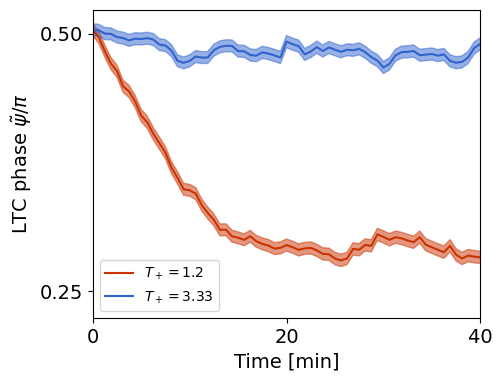

In [ ]:
fig = plt.figure(figsize=(5, 4))

plt.plot(time, median_ltc_sat[:,0]/np.pi, color='#ca3300ff', label=r"$T_+ = 1.2$") 
plt.fill_between(time, (median_ltc_sat-std_err_ltc_sat)[:,0]/np.pi, (median_ltc_sat+std_err_ltc_sat)[:,0]/np.pi,  color='#ca3300ff', alpha=0.5)

plt.plot(time, median_ltc_nonsat[:,0]/np.pi, color='#3163ceff',  label=r"$T_+ = 3.33$")
plt.fill_between(time, (median_ltc_nonsat-std_err_ltc_nonsat)[:,0]/np.pi, (median_ltc_nonsat+std_err_ltc_nonsat)[:,0]/np.pi,  color='#3163ceff', alpha=0.5)

plt.ylabel(r"LTC phase $\tilde{\psi}/\pi$", fontsize=14)
plt.yticks([0.25, 0.5], fontsize=14)

plt.legend()

plt.xlim([0, 40])
plt.xlabel("Time [min]", fontsize=14)
plt.xticks([0, 20, 40], fontsize=14)

#plt.savefig(f"{plot_dir}/fig_5_ltc/saturating_feedback_median_ltc_vs_time_std_err.pdf")

In [ ]:
## save LTC histograms

In [ ]:
bins = [dln.eqspace(0, 1+.01, .1), dln.eqspace(0, 1+.01, .1)] # for histograms

ltc_combined = np.vstack([ltc_dict_mean[("orthogonal", 1.2)].T, ltc_dict_mean[("parallel", 1.2)].T]).transpose((1, 2, 0))
ltc_combined.shape

(2, 100, 4896)

In [ ]:
def flatten_t(arr):
    return arr.reshape((arr.shape[0], arr.shape[1]*arr.shape[2])) 

In [ ]:
late_saturating = flatten_t(ltc_combined[:,48:52])
np.savetxt(f"{plot_dir}/fig_5_ltc/saturating_ltc_t=30min.txt", late_saturating)

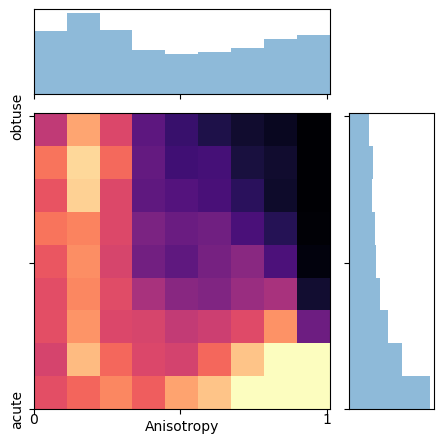

  0%|          | 0/100 [00:00<?, ?it/s]


In [ ]:
## early

fig = plt.figure(figsize=(5, 5))

ax = dln.scatter_hist(late_saturating[1], late_saturating[0]/np.pi, bins, fig=fig, vmax=1.8)

ax.set_ylabel("", labelpad=-5)
ax.set_xlabel("Anisotropy", labelpad=-5)
ax.set_xticks([0, 1/2, 1], [0, "", 1], rotation=0, va='center') 
ax.set_yticks([0, 1/2, 1], ["acute", "", r"obtuse"], rotation=90, va='center')

plt.savefig(f"{plot_dir}/fig_5_ltc/saturating_ltc_t=0min.pdf")

## Large hard disk meshes for limiting distributinon

Compare: psi = 0.5, magnitude = 0.5.

In [241]:
base_dir = "/data/Nikolas/GBE_simulation/runs/hard_disks/hard_disk_ltc_samples"

def load_data(eta):
    sim_dir = f"{base_dir}/eta_{eta}_randomSeed_{None}_mesh"
    mesh = iso.CellHalfEdgeMesh.load_mesh(sim_dir)
    ltc_dist = tns.angles_shape(np.array(list(mesh.get_vertex_angles(exclude=None, method="dual").values())).T)
    return mesh, ltc_dist


In [242]:
etas = np.round(np.linspace(0.2, 0.65, 10), decimals=2)
etas

array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65])

In [243]:
%%time

my_data = Parallel(n_jobs=12, prefer=None, timeout=99999)(delayed(load_data)(eta) for eta in etas)

CPU times: user 1.63 s, sys: 8.94 s, total: 10.6 s
Wall time: 13.2 s


In [244]:
ltcs_eta = {key: val[1] for key, val in zip(etas, my_data)}
meshes_eta = {key: val[0] for key, val in zip(etas, my_data)}

In [246]:
eta = 0.3
len(meshes_eta[eta].vertices)

4716

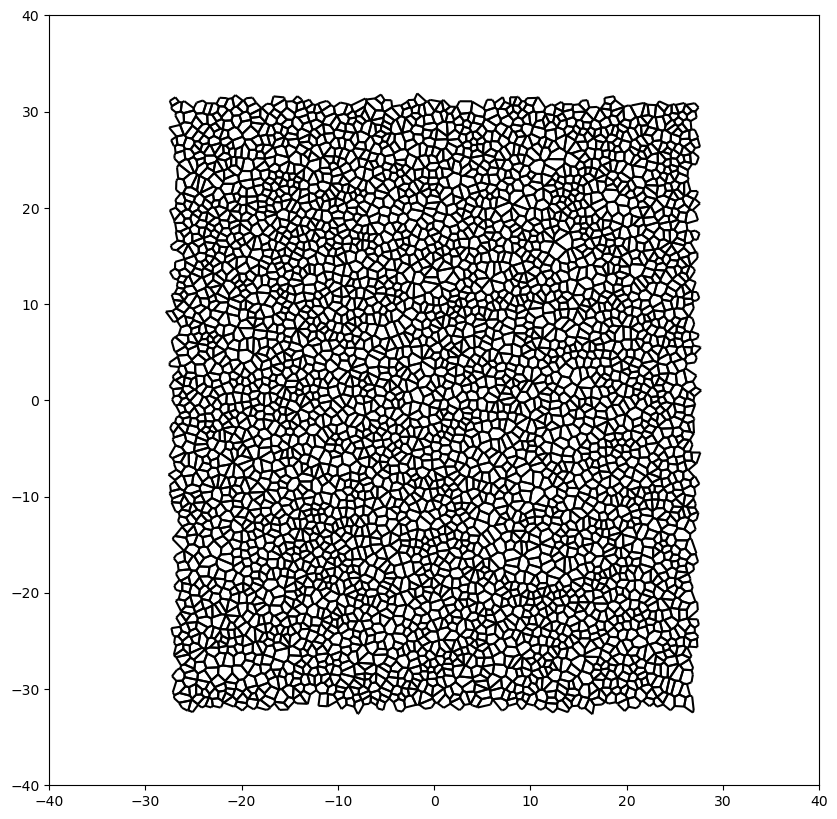

In [247]:
bdry_x, bdry_y = (40, 40)
t = -1

eta =0.25

fig, ax = plt.subplots(figsize=(10, 10))

meshes_eta[eta].cellplot()

ax.set_xlim([-bdry_x, bdry_x])
ax.set_ylim([-bdry_y, bdry_y])
ax.set_aspect("equal", adjustable="box")

In [248]:
medians_eta = {key: np.round(np.median(val, axis=1)/np.array([np.pi, 1]), decimals=2) for key, val in ltcs_eta.items()}
medians_eta

# 0.25 looks like a good fit, or 0.3

{0.2: array([0.48, 0.56]),
 0.25: array([0.48, 0.53]),
 0.3: array([0.52, 0.51]),
 0.35: array([0.53, 0.48]),
 0.4: array([0.55, 0.45]),
 0.45: array([0.56, 0.42]),
 0.5: array([0.59, 0.4 ]),
 0.55: array([0.63, 0.36]),
 0.6: array([0.66, 0.33]),
 0.65: array([0.7 , 0.28])}

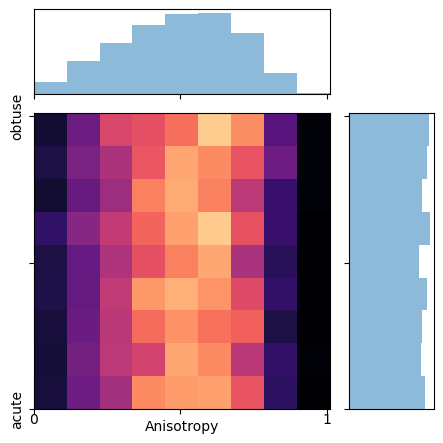

In [252]:
eta = 0.3

fig = plt.figure(figsize=(5, 5))

ax = dln.scatter_hist(ltcs_eta[eta][1], ltcs_eta[eta][0]/np.pi, bins, fig=fig, vmax=2.2)

ax.set_ylabel("", labelpad=-5)
ax.set_xlabel("Anisotropy", labelpad=-5)
ax.set_xticks([0, 1/2, 1], [0, "", 1], rotation=0, va='center') 
ax.set_yticks([0, 1/2, 1], ["acute", "", r"obtuse"], rotation=90, va='center')

plt.savefig(f"{plot_dir}/fig_5_ltc/rho={eta}.pdf")

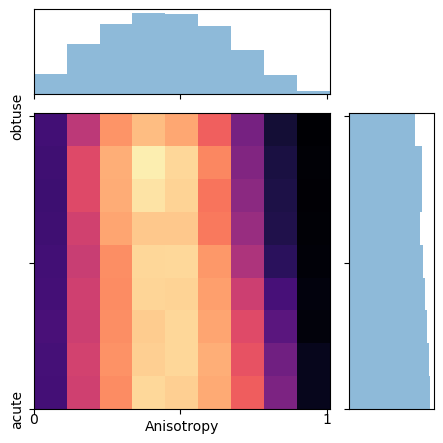

In [250]:
[np.savetxt(f"{plot_dir}/fig_5_ltc/rho={eta}.txt", ltcs_eta[eta]) for eta in etas]

[None, None, None, None, None, None, None, None, None, None]